In [1]:
#!pip install celery

In [2]:
#!sudo rabbitmqctl add_user myguest myguestpwd
#!sudo rabbitmqctl set_permissions -p / myguest "." "." ".*"

**The below code will use 4 workers**

On each of the workers you will neeed to run: <br>
<code> celery -A kmeans_workers_v2 worker --loglevel=info --concurrency=1 </code>

In [3]:
!sudo rabbitmqctl list_users

Listing users ...
guest	[administrator]
myguest	[]


In [4]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import json

from sklearn.datasets import make_blobs
from copy import deepcopy

from celery import group
from kmeans_workers_v2 import kmeans_tasks, dist, NumpyEncoder


### Creating a dataset

In [5]:
n_samples=16000
n_clusters=3
n_features =2
n_workers = 4 #Check that celery also uses 4 workers!!!

In [6]:
np.random.seed(seed=1023)

In [7]:
# Creating a n_features=2 Dim dataset with centers=3 clusters
Xs, Ys = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters, shuffle =False)

In [8]:
Ys

array([0, 0, 0, ..., 2, 2, 2])

In [9]:
mydata= [{"points": x, "label": y} for x,y in zip(Xs,Ys)]

In [10]:
print(len(mydata))
print(mydata[15]['points'],mydata[15]['label'])

16000
[7.4123751  1.65861249] 0


In [11]:
# Split the sequence in a number of chunks and process those independently.

if 0:
    l = n_samples // n_workers
    Xsubseqs = [mydata[i * l:(i + 1) * l] for i in range(n_workers - 1)]
    Xsubseqs.append(mydata[(n_workers - 1) * l:])
else:
    splitting_points=[3000,7000,8000]
    Xsubseqs=[]
    Xsubseqs.append(mydata[0:splitting_points[0]])
    Xsubseqs.append(mydata[splitting_points[0]:splitting_points[1]])
    Xsubseqs.append(mydata[splitting_points[1]:splitting_points[2]])
    Xsubseqs.append(mydata[splitting_points[2]:])
    
for i in range(len(Xsubseqs)):
    print(len(Xsubseqs[i]))

3000
4000
1000
8000


In [12]:
np.matrix(np.diag(np.max(Xs,0)))

matrix([[11.87536783,  0.        ],
        [ 0.        ,  8.26562541]])

In [13]:
C=np.matrix(np.random.rand(n_clusters,n_features))*np.matrix(np.diag(np.max(Xs,0)))
print("Initial Centroids")
print(C)
C_start=C

Initial Centroids
[[10.71854272  0.65915336]
 [ 1.78003584  8.22716699]
 [ 3.07457675  0.19630368]]


**Show the dataset**

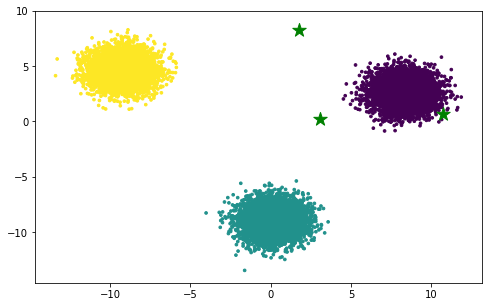

In [14]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 5)
fig = plt.figure()

# Plotting along with the Centroids
#plt.scatter([actdata.points[0] for actdata in mydata], [actdata.points[1] for actdata in mydata])
plt.scatter([actdata['points'][0] for actdata in mydata], [actdata['points'][1] for actdata in mydata],c=[actdata['label'] for actdata in mydata], s=7)

plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')


In [15]:
len(Xsubseqs[0])

3000

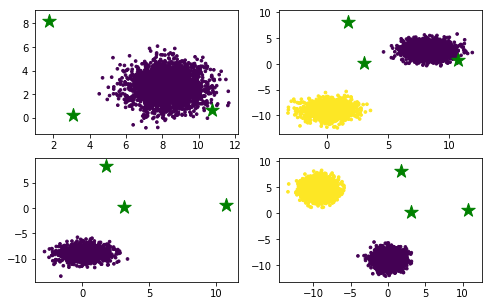

In [16]:

fig, axs = plt.subplots(2, 2)
tmpdata = Xsubseqs[0]
axs[0,0].scatter([actdata['points'][0] for actdata in tmpdata], [actdata['points'][1] for actdata in tmpdata],c=[actdata['label'] for actdata in tmpdata], s=7)
axs[0,0].scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')

tmpdata = Xsubseqs[1]
axs[0,1].scatter([actdata['points'][0] for actdata in tmpdata], [actdata['points'][1] for actdata in tmpdata],c=[actdata['label'] for actdata in tmpdata], s=7)
axs[0,1].scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')

tmpdata = Xsubseqs[2]
axs[1,0].scatter([actdata['points'][0] for actdata in tmpdata], [actdata['points'][1] for actdata in tmpdata],c=[actdata['label'] for actdata in tmpdata], s=7)
axs[1,0].scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')

tmpdata = Xsubseqs[3]
axs[1,1].scatter([actdata['points'][0] for actdata in tmpdata], [actdata['points'][1] for actdata in tmpdata],c=[actdata['label'] for actdata in tmpdata], s=7)
axs[1,1].scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')


In [17]:
len([actdata['label'] for actdata in mydata])

16000

In [18]:
print(C)
print(C.shape)

[[10.71854272  0.65915336]
 [ 1.78003584  8.22716699]
 [ 3.07457675  0.19630368]]
(3, 2)


### Distributed Kmeans

#### Upload the data to the workers

In [19]:
#Let us upload data to the workers
response = group(kmeans_tasks.s(task='data_to_workers', json_dump = json.dumps({'C': C, 'X': seq,'n_clusters': n_clusters, 'n_features':n_features}, cls=NumpyEncoder)) 
                                               for seq in Xsubseqs)() 

response.get()

['success: 3000 points uploaded',
 'success: 4000 points uploaded',
 'success: 1000 points uploaded',
 'success: 8000 points uploaded']

In [20]:
starttime = time.time()
n_iter =15
for iter in range(0, n_iter):
    print(f'**** EM Iteration: {iter} ****')
    
    lazy_partials_EMstep = group(kmeans_tasks.s(task='EM_step', json_dump = json.dumps({'C': C}, cls=NumpyEncoder)) 
                                                   for seq in Xsubseqs)() 
    # call remote workers to run the sort task 
    partials_EMstep = lazy_partials_EMstep.get() # will wait for the tasks to return
    
    print('------ partials_EMsteps ------')
    for it, val in enumerate(partials_EMstep):
        print(f'{it}: {val}')
    print('------------')
    
    print('\n *** All workers are done with their tasks *** \n')
    partials_C=[json.loads(seq)['C'] for seq in partials_EMstep]
    
    print('----- C -------')
    for it, val in enumerate(partials_C):
        print(f'{it}: {val}')
    print('------------\n')
    
    partials_num_points=[json.loads(seq)['num_points'] for seq in partials_EMstep]
    
    print('----- num_points -------')
    for it, val in enumerate(partials_num_points):
        print(f'{it}: {val}')
    print('------------')
    
    print('\n *** Aggregation on the server *** \n')
    
    #aggregation by th server
    C=np.zeros([n_clusters,n_features])
    
    for i in range(n_clusters):
        for j in range(n_workers):
             C[i,:]=C[i,:]+partials_num_points[j][i]*np.array(partials_C[j][i])

    num_points=np.sum(np.array(partials_num_points),0)
    print('num_points in clusters:', num_points)
    
    for i in range(n_clusters):
        if num_points[i]>0:
            C[i,:]=C[i,:]/num_points[i]
    
    print('\n *** Aggregation done *** \n')
    
endtime = time.time()


**** EM Iteration: 0 ****
------ partials_EMsteps ------
0: {"C": [[8.421611689321276, 2.5849768614684594], [6.261813510050014, 5.410757706278982], [6.290452543863016, 2.488391847853143]], "num_points": [2805, 3, 192]}
1: {"C": [[8.425326073244577, 2.635763183730229], [6.390232549689203, 4.988473295946204], [0.6682870479458065, -8.077680213205886]], "num_points": [2191, 2, 1807]}
2: {"C": [[0.0, 0.0], [0.0, 0.0], [0.1904232508542879, -8.928591439189825]], "num_points": [0, 0, 1000]}
3: {"C": [[0.0, 0.0], [-9.218818609982748, 4.679838383435121], [-0.0028983393377660783, -8.718250694206105]], "num_points": [0, 5277, 2723]}
------------

 *** All workers are done with their tasks *** 

----- C -------
0: [[8.421611689321276, 2.5849768614684594], [6.261813510050014, 5.410757706278982], [6.290452543863016, 2.488391847853143]]
1: [[8.425326073244577, 2.635763183730229], [6.390232549689203, 4.988473295946204], [0.6682870479458065, -8.077680213205886]]
2: [[0.0, 0.0], [0.0, 0.0], [0.1904232508

------ partials_EMsteps ------
0: {"C": [[8.28305770583268, 2.5816212014418913], [0.0, 0.0], [0.0, 0.0]], "num_points": [3000, 0, 0]}
1: {"C": [[8.29938430037866, 2.6345824590167024], [0.0, 0.0], [0.18577528819479716, -8.97992168215078]], "num_points": [2334, 0, 1666]}
2: {"C": [[0.0, 0.0], [0.0, 0.0], [0.1904232508542879, -8.928591439189825]], "num_points": [0, 0, 1000]}
3: {"C": [[0.0, 0.0], [-9.213704163324087, 4.652075349708317], [0.18038482193912803, -8.94405974163125]], "num_points": [0, 5333, 2667]}
------------

 *** All workers are done with their tasks *** 

----- C -------
0: [[8.28305770583268, 2.5816212014418913], [0.0, 0.0], [0.0, 0.0]]
1: [[8.29938430037866, 2.6345824590167024], [0.0, 0.0], [0.18577528819479716, -8.97992168215078]]
2: [[0.0, 0.0], [0.0, 0.0], [0.1904232508542879, -8.928591439189825]]
3: [[0.0, 0.0], [-9.213704163324087, 4.652075349708317], [0.18038482193912803, -8.94405974163125]]
------------

----- num_points -------
0: [3000, 0, 0]
1: [2334, 0, 1666]


In [21]:
print('Elapsed time: ', endtime - starttime)

Elapsed time:  2.308420419692993


In [22]:
partials_num_points

[[3000, 0, 0], [2334, 0, 1666], [0, 0, 1000], [0, 5333, 2667]]

### Show the Results

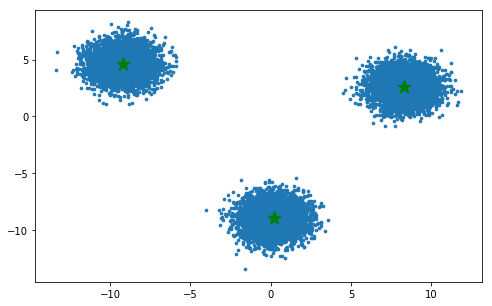

In [23]:
plt.rcParams['figure.figsize'] = (8, 5)
fig = plt.figure()
plt.scatter([actdata['points'][0] for actdata in mydata], [actdata['points'][1] for actdata in mydata], s=7)

plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')
plt.show()


### Standard non-distributed kMeans clustering running on the server

**Let us compare the running time of the distributed kmeans with the non-distributed kmeans 

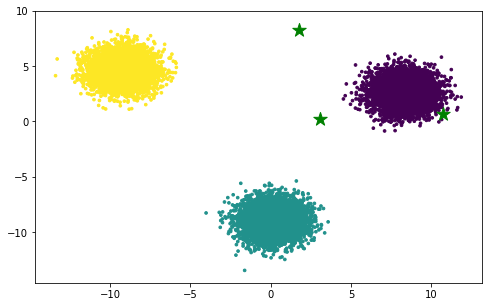

In [24]:
C=C_start # start it from the same starting point

#plt.scatter([actdata.points[0] for actdata in mydata], [actdata.points[1] for actdata in mydata],c='#050505', s=7)
plt.scatter([actdata['points'][0] for actdata in mydata], [actdata['points'][1] for actdata in mydata],c=[actdata['label'] for actdata in mydata], s=7)
plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')


In [25]:
# Set up variable X in the kmeans_tasks function
kmeans_tasks(task='data_to_workers', json_dump = json.dumps({'C': C, 'X': mydata,'n_clusters': n_clusters, 
                                                                        'n_features':n_features}, cls=NumpyEncoder)) 

n_clusters: 3
n_features: 2


'success: 16000 points uploaded'

In [26]:
starttime = time.time()
for iter in range(0, n_iter): 
    results=kmeans_tasks(task='EM_step', json_dump = json.dumps({'C': C}, cls=NumpyEncoder)) 
    C=np.array(json.loads(results)['C'])
endtime = time.time()
print('Elapsed time: ', endtime - starttime)

*** we are in the E-Step ***
E step iter: 1
 *** Labels updated. E-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the E-Step ***
E step iter: 2
 *** Labels updated. E-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the E-Step ***
E step iter: 3
 *** Labels updated. E-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the E-Step ***
E step iter: 4
 *** Labels updated. E-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the E-Step ***
E step iter: 5
 *** Labels updated. E-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the E-Step ***
E step iter: 6
 *** Labels updated. E-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the E-Step ***
E step iter: 7
 *** Labels updated.

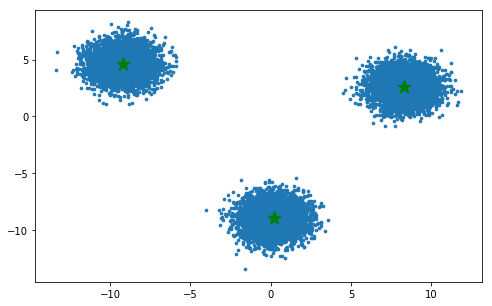

In [27]:
plt.rcParams['figure.figsize'] = (8, 5)
fig = plt.figure()
plt.scatter([actdata['points'][0] for actdata in mydata], [actdata['points'][1] for actdata in mydata], s=7)

plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')
plt.show()
